# Overview
**Goal**: do some comparison of snow depth derived from snow-on/snow-off vs ASO snow depth product

Loading Data
* Snow-on ASO depth product from February 2 2020, 3m resolution
* Snow-off USGS 3DEP DEM, 1m resolution
* ASO snow-on DEM (not in SnowEx database)

Coregistration
* Get these into the same horizontal and vertical reference frames. How do we access the metadata for each?
* Resample to the larger of the grids
* How to align? Try the demcoreg tool? Which features do we use to co-register? Unlike glaciers we don't have the glacier inventory polygons. We do have roads in the middle of Grand Mesa to use...
    * Shashank: for glaciers, we can find features from shaded relief maps to find horizontal displacements. But for snow-on vs snow-off, maybe we can use the road (if plowed?)
    * (Coming) Shashank recipe for horizontal then vertical correction?
    * Can start with traditional dem alignment method that works on slope aspect and elevation. Nuth Kaab or ICP, can use the PDAL and ASP implementations

Comparison with ASO Snow Depth
* compare to ASO snow depth product - is it a raster that we can project into the same grid? difference our_snow_depth vs aso_snow_depth)

# Load the data

## Import the functions and classes we need to interact with the SnowEx database

In [27]:
import os

import numpy as np
import rioxarray
import rasterio

In [48]:
# Import the function to get connect to the db
from snowexsql.db import get_db
# Import our class for the points, layer, image tables
from snowexsql.data import PointData, LayerData, ImageData

# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 

# Import this to convert to a rasterio object for easy plotting
from snowexsql.conversions import raster_to_rasterio 

# Import a convenient function to plot with 
from rasterio.plot import show

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [3]:
# result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.surveyors == 'USGS').limit(1).all()
# print(result)
result = session.query(ImageData.surveyors).distinct().all()
print(result)
result = session.query(ImageData.type).distinct().all()
print(result)
result = session.query(ImageData.date).distinct().all()
print(result)


[('USGS',), ('UAVSAR team, JPL',), ('ASO Inc.',)]
[('swe',), ('DEM',), ('insar amplitude',), ('insar correlation',), ('depth',), ('insar interferogram real',), ('insar interferogram imaginary',)]
[(datetime.date(2020, 2, 12),), (datetime.date(2020, 2, 13),), (None,), (datetime.date(2020, 1, 31),), (datetime.date(2020, 2, 2),)]


## Since the ASO DEMs are not in the SnowEx database, we download them separately from AWS

In [4]:
if not os.path.exists("ASO_GrandMesa_dems_2020Feb1-2.zip"):
    !wget https://asopublic.s3-us-west-1.amazonaws.com/USCO/GM/2020/0201/ASO_GrandMesa_dems_2020Feb1-2.zip

In [5]:
if not os.path.exists("ASO_GrandMesa_dems_2020Feb1-2/"):
    !for f in ASO*zip ; do unzip ${f} ; done
!ls ASO_GrandMesa_dems_2020Feb1-2/

ASO_GrandMesa_Mosaic_2020Feb1-2_dtmvf_mos_3m.tif
ASO_GrandMesa_Mosaic_2020Feb1-2_fsrdemvf_mos_3m.tif
ASO_snowfree_GrandMesa_2016Sep26_dtmvf_mos_3m.tif
ASO_snowfree_GrandMesa_2016Sep26_fsrdemvf_mos_3m.tif


Question: we have DTM & DEM. What do FSR and VF mean? ??? and maybe Vegetation-Free?

In [6]:
aso_dem_fsr_vf = rioxarray.open_rasterio("ASO_GrandMesa_dems_2020Feb1-2/ASO_GrandMesa_Mosaic_2020Feb1-2_fsrdemvf_mos_3m.tif")#fn, masked=True, default_name=name, long_name=name).squeeze(dim='band', drop=True)
aso_dem_fsr_vf

<xarray.DataArray (band: 1, y: 3528, x: 7576)>
[26728128 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.375e+05 7.375e+05 ... 7.602e+05 7.602e+05
  * y            (y) float64 4.33e+06 4.33e+06 4.33e+06 ... 4.32e+06 4.32e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Band 1

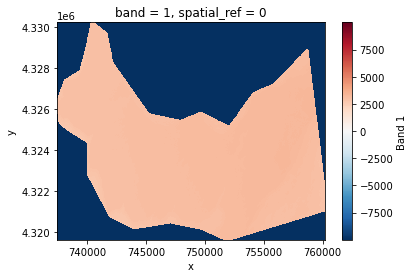

In [7]:
aso_dem_fsr_vf.plot()

That plot looks odd, let's check the range of values

In [8]:
print(aso_dem_fsr_vf.min())
print(aso_dem_fsr_vf.max())

<xarray.DataArray ()>
array(-9999., dtype=float32)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(3313.1692, dtype=float32)
Coordinates:
    spatial_ref  int64 0


<xarray.DataArray ()>
array(2684.3748, dtype=float32)
Coordinates:
    spatial_ref  int64 0


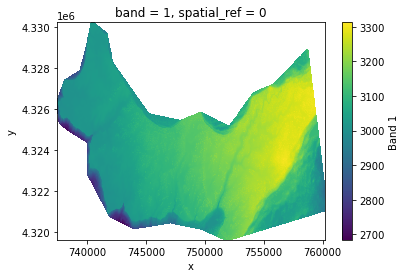

In [9]:
# bad = aso_dem_fsr_vf.where(aso_dem_fsr_vf == -9999)
aso_dem_fsr_vf = aso_dem_fsr_vf.where(aso_dem_fsr_vf != -9999, np.nan)
print(aso_dem_fsr_vf.min())
aso_dem_fsr_vf.plot()

In [10]:
rioxarray.open_rasterio("ASO_GrandMesa_dems_2020Feb1-2/ASO_GrandMesa_Mosaic_2020Feb1-2_dtmvf_mos_3m.tif")

<xarray.DataArray (band: 1, y: 3528, x: 7576)>
[26728128 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.375e+05 7.375e+05 ... 7.602e+05 7.602e+05
  * y            (y) float64 4.33e+06 4.33e+06 4.33e+06 ... 4.32e+06 4.32e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Band 1

## ASO Snow Depth product from SnowEx database

In [20]:
query = session.query(ImageData.date)
query = query.filter(ImageData.surveyors == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.distinct()
result = query.all()
print(result)

[(datetime.date(2020, 2, 2),), (datetime.date(2020, 2, 13),)]


We can see that the ASO snow **depth** products (not to be confused with the DEMs) are from 2020-02-02 and 2020-02-13. We'll stick to 2020-02-02 for this analysis.

In [49]:
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.surveyors == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")
result = query.count()
print(result)

128


It appears that we have 128 different ASO depth tiles to work with. Can we plot the tiles on the map?

[(<memory at 0x7f30e8571700>,), (<memory at 0x7f30e8571040>,), (<memory at 0x7f30e8571940>,), (<memory at 0x7f308512d040>,), (<memory at 0x7f308512d100>,)]
datasets:  <class 'list'>
datasets[2]: <open DatasetReader name='/vsimem/09f3a89d-6803-4c32-bf0a-7cce4ac0071e/09f3a89d-6803-4c32-bf0a-7cce4ac0071e.tif' mode='r'> <class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
(500, 500)


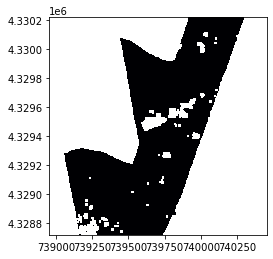

<AxesSubplot:>

In [50]:
# Retrieve some of the ASO Snow Depth tiles
query = session.query(func.ST_AsTiff(ImageData.raster))
query = query.filter(ImageData.surveyors == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")
query = query.limit(5)
result = query.all()
print(result)
datasets = raster_to_rasterio(session, result)
print('datasets: ', type(datasets))
print('datasets[2]:', datasets[2], type(datasets[0]))


array = datasets[2].read(1) # Read the only band from our DEM into a numpy array, which would lose the coordinate system
print(type(array))
print(array.shape)

# Plot the georeferenced image 
show(datasets[2], cmap='magma')

## Get the USGS 3DEP product from the database and read it in as a rioxarray array for later use
Note: rioxarray can't read the `rasterio.io.DatasetReader` directly, instead it tries to open the .tif file which is not on our machine. Workaround: save the TIFF as a local file and point rioxarray to that.

In [46]:
result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.surveyors == 'USGS').count()
print("Number of 3DEP tiles:", result)

Number of 3DEP tiles: 1713


Can we merge these tiles into a single VRT? Need to use gdalbuildvrt? https://github.com/snowex-hackweek/website/blob/main/book/tutorials/geospatial/geospatial_cookbook_rendered.ipynb

datasets:  <class 'list'>
raster: <open DatasetReader name='/vsimem/8da3cefb-ecbf-475d-aeae-2b7489fd425d/8da3cefb-ecbf-475d-aeae-2b7489fd425d.tif' mode='r'> <class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
(500, 500)


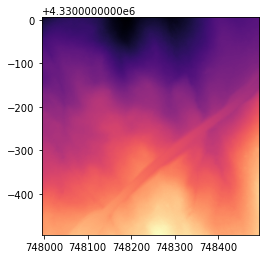

/vsimem/8da3cefb-ecbf-475d-aeae-2b7489fd425d/8da3cefb-ecbf-475d-aeae-2b7489fd425d.tif ???


<xarray.DataArray (band: 1, y: 500, x: 500)>
[250000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.48e+05 7.48e+05 7.48e+05 ... 7.485e+05 7.485e+05
  * y            (y) float64 4.33e+06 4.33e+06 4.33e+06 ... 4.33e+06 4.33e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -3.4028234663852886e+38
    scale_factor:  1.0
    add_offset:    0.0

In [43]:
# Remember in the query parentheses is what we get back, in this case were asking for the raster data as a geotiff

result = session.query(func.ST_AsTiff(ImageData.raster)).filter(ImageData.surveyors == 'USGS').limit(1).all()

# Now make it more available as a python object 
datasets = raster_to_rasterio(session, result)
raster = datasets[0]
raster_id = "???" # not sure how to retrieve the other tile metadata?
print('datasets: ', type(datasets))
print('raster:', raster, type(raster))

array = raster.read(1) # Read the only band from our DEM into a numpy array, which would lose the coordinate system
print(type(array))
print(array.shape)

# Plot the georeferenced image 

show(raster, cmap='magma')
print(raster.name, raster_id)

# Write our raster to disk
# Copy the profile/tiff metadata (not to be confused with the database metadata)
profile = raster.profile
filename = f"raster{raster_id}.tif"
with rasterio.open(filename, 'w', **profile) as dst:
    dst.write(raster.read(1), 1)

# Reopen with rioxarray
da = rioxarray.open_rasterio(filename)
da

# Common reference frame + coregistration

## Check the metadata for each of our rasters

# Analysis

In [ ]:
# Close out the session to avoid hanging transactions
session.close()